<a href="https://colab.research.google.com/github/Pengyu-gis/Historical-Aerial-Photos/blob/main/Tif_Colorization/DDColor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q addict datasets simplejson sortedcontainers opencv-python rasterio modelscope

In [ ]:
import cv2
import rasterio
from modelscope.pipelines import pipeline
from modelscope.outputs import OutputKeys
from modelscope.utils.constant import Tasks
import numpy as np
import os

In [ ]:
with rasterio.open(input_tif) as src:
    img_array = src.read(1)
    print("Original min:", np.min(img_array), "Original max:", np.max(img_array))


Original min: 92 Original max: 234


In [ ]:
# Compute min and max from the image
img_min = np.min(img_array)
img_max = np.max(img_array)

# Avoid division by zero if img_max equals img_min
if img_max - img_min == 0:
    img_norm = np.zeros_like(img_array, dtype=np.uint8)
else:
    img_norm = ((img_array - img_min) / (img_max - img_min) * 255).astype(np.uint8)


In [ ]:
# 1. Read the input GeoTIFF using Rasterio and extract metadata
input_tif = '/content/drive/MyDrive/aerial_photos/45019_1979_0178_0071_x_24.tif'
with rasterio.open(input_tif) as src:
    meta = src.meta.copy()  # Save georeference and other metadata
    # Read the first band; adjust if your tif has more than one band.
    img_array = src.read(1)  # Assuming a single-channel (grayscale) image
    # Convert the single-channel image to a 3-channel image
    img_3ch = cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)

# 2. Save the temporary image in a standard format (PNG or JPEG) that the pipeline accepts.
temp_img_path = 'temp_input.png'
img_norm = cv2.normalize(img_array, None, 0, 255, cv2.NORM_MINMAX)
img_norm = img_norm.astype(np.uint8)
img_3ch = cv2.cvtColor(img_norm, cv2.COLOR_GRAY2BGR)
cv2.imwrite('temp_input.png', img_3ch)

# 3. Load and run the DDColor pipeline for image colorization.
img_colorization = pipeline(Tasks.image_colorization, model='damo/cv_ddcolor_image-colorization')
result = img_colorization(temp_img_path)
colored_img = result[OutputKeys.OUTPUT_IMG]  # This output is typically in BGR format.

# 4. Convert from BGR to RGB (if you prefer the more common ordering when saving via Rasterio)
colored_img_rgb = cv2.cvtColor(colored_img, cv2.COLOR_BGR2RGB)

# 5. Write the colored image back to a GeoTIFF.
# Update metadata to indicate 3 bands (for R, G, B) and the proper data type.
meta.update({'count': 3, 'dtype': 'uint8'})
meta.pop('nodata', None)
output_tif = '/content/drive/MyDrive/aerial_photos/square_patches/DDColor-output.tif'
with rasterio.open(output_tif, 'w', **meta) as dst:
    dst.write(colored_img_rgb[:, :, 0], 1)  # Red channel
    dst.write(colored_img_rgb[:, :, 1], 2)  # Green channel
    dst.write(colored_img_rgb[:, :, 2], 3)  # Blue channel

print("Colorization complete. Output saved to", output_tif)

2025-02-21 23:02:44,046 - modelscope - WARNING - Model revision not specified, use revision: v1.02


2025-02-21 23:02:45,823 - modelscope - WARNING - Model revision not specified, use revision: v1.02
2025-02-21 23:02:46,208 - modelscope - INFO - initiate model from /root/.cache/modelscope/hub/models/damo/cv_ddcolor_image-colorization
2025-02-21 23:02:46,209 - modelscope - INFO - initiate model from location /root/.cache/modelscope/hub/models/damo/cv_ddcolor_image-colorization.
2025-02-21 23:02:46,211 - modelscope - INFO - initialize model from /root/.cache/modelscope/hub/models/damo/cv_ddcolor_image-colorization
2025-02-21 23:02:50,612 - modelscope - INFO - Loading DDColor model from /root/.cache/modelscope/hub/models/damo/cv_ddcolor_image-colorization/pytorch_model.pt, with param key: [params].
2025-02-21 23:02:50,838 - modelscope - INFO - load model done.
2025-02-21 23:02:50,890 - modelscope - WARNING - No preprocessor field found in cfg.
2025-02-21 23:02:50,890 - modelscope - WARNING - No val key and type key found in preprocessor domain of configuration.json file.
2025-02-21 23:02

Colorization complete. Output saved to output.tif


2025-02-21 23:02:58,345 - modelscope - WARNING - Model revision not specified, use revision: v1.02


2025-02-21 23:02:59,675 - modelscope - WARNING - Model revision not specified, use revision: v1.02
2025-02-21 23:02:59,966 - modelscope - INFO - initiate model from /root/.cache/modelscope/hub/models/damo/cv_ddcolor_image-colorization
2025-02-21 23:02:59,967 - modelscope - INFO - initiate model from location /root/.cache/modelscope/hub/models/damo/cv_ddcolor_image-colorization.
2025-02-21 23:02:59,969 - modelscope - INFO - initialize model from /root/.cache/modelscope/hub/models/damo/cv_ddcolor_image-colorization
2025-02-21 23:03:04,353 - modelscope - INFO - Loading DDColor model from /root/.cache/modelscope/hub/models/damo/cv_ddcolor_image-colorization/pytorch_model.pt, with param key: [params].
2025-02-21 23:03:04,585 - modelscope - INFO - load model done.
2025-02-21 23:03:04,636 - modelscope - WARNING - No preprocessor field found in cfg.
2025-02-21 23:03:04,636 - modelscope - WARNING - No val key and type key found in preprocessor domain of configuration.json file.
2025-02-21 23:03

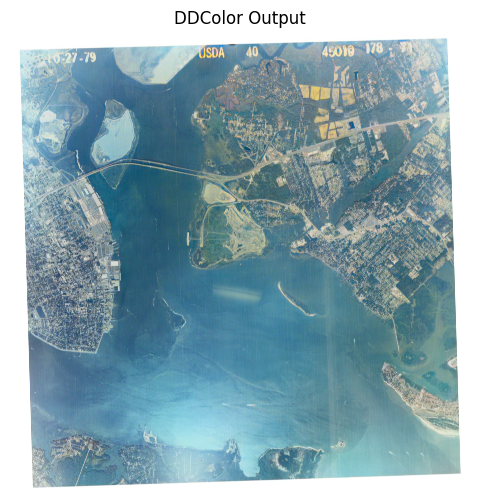

In [ ]:
import matplotlib.pyplot as plt

img_colorization = pipeline(Tasks.image_colorization, model='damo/cv_ddcolor_image-colorization')
result = img_colorization('temp_input.png')
colored_img = result[OutputKeys.OUTPUT_IMG]

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(colored_img, cv2.COLOR_BGR2RGB))
plt.title("DDColor Output")
plt.axis('off')
plt.show()
